In [1]:
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier, MedPFNClassifier
from tabpfn_new.scripts.model_builder import load_model
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
#from load_models import *
import matplotlib.pyplot as plt
import math
import torch
import openml
import time
#pd.set_option('display.expand_frame_repr', False)

In [2]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=42)

### Feature importance - Leave-one-covariate-out (LOCO)

Currently at feature:  0
Currently at feature:  100
Currently at feature:  200
Currently at feature:  300
Currently at feature:  400
Currently at feature:  500
Currently at feature:  600
Currently at feature:  700


(array([  3., 735.,   3.,   0.,   1.,   3.,   1.,   2.,   1.,   1.]),
 array([-0.00398746, -0.00025874,  0.00346998,  0.0071987 ,  0.01092742,
         0.01465614,  0.01838486,  0.02211358,  0.02584229,  0.02957101,
         0.03329973]),
 <BarContainer object of 10 artists>)

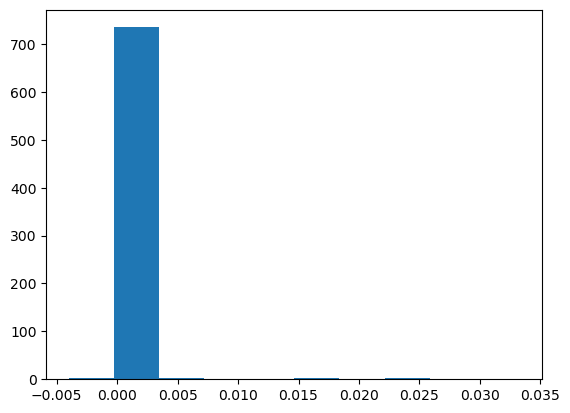

In [50]:
save = True
sampling = None
cv = 3
best_delete = 0
strat_split = True
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"

model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)
model = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
reducer = AnovaSelect()

results, _ = cross_validate_sample(model, all_data, labels, metrics, strat_split, cv, sampling, 
                                   reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)


In [ ]:
rocs = []
f1s = []
for f in range(0,750):
    if f%100==0:
        print("Currently at feature: ", f)
    loco_data = np.delete(all_data,f,axis=1)
    loco_results, _ = cross_validate_sample(model, loco_data, labels, metrics, strat_split, cv, sampling, 
                                   reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)
    #model.pred_model.model[2].zero_grad()
    rocs.append(loco_results[0])
    f1s.append(loco_results[1])
rocs = results[0]-np.array(rocs)
f1s = results[1]-np.array(f1s)
red_name ="fi-loco"
directory = f"results/{red_name}"
if not os.path.exists(directory):
    os.makedirs(directory)
if save:
    np.save(f"results/{red_name}/xgb_rocs1.npy", rocs)
    np.save(f"results/{red_name}/xgb_f1s1.npy", f1s)
#plt.hist(rocs)

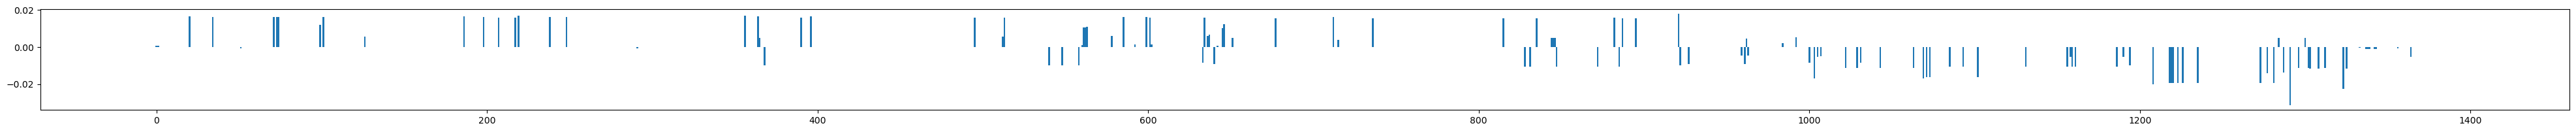

(1391,)
[1291 1323 1208 ...  219  356  921]


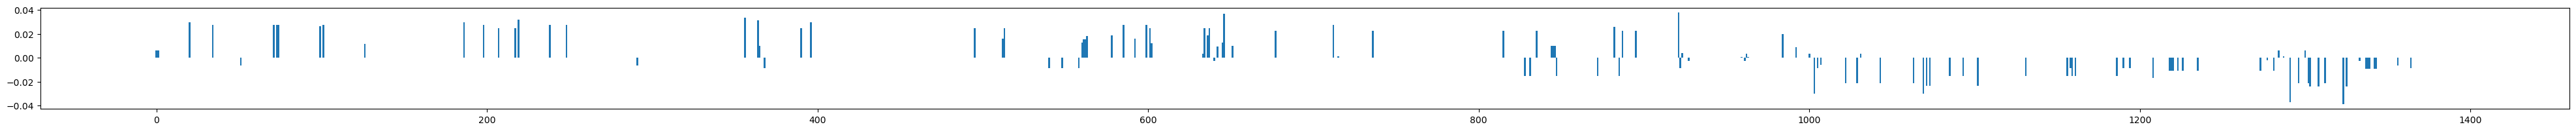

(1391,)
[1323 1291 1003 ...  356  646  921]


In [15]:
for m in ["rocs", "f1s"]:
    red_name ="fi-loco"
    file1 = np.load(f"results/{red_name}/{m}1.npy")
    file2 = np.load(f"results/{red_name}/{m}2.npy")
    full = np.concatenate((file1, file2), axis=0)
    plt.figure(figsize=(50,2), dpi=100)
    #plt.hist(full, bins=100)
    plt.bar(np.arange(full.shape[0]),full, width=1)
    plt.show()
    print(full.shape)
    print(np.argsort(full))
    best = np.argsort(full)

In [ ]:
plt.hist(results[0]-np.array(rocs))
plt.show()
plt.scatter(np.arange(len(rocs)), results[0]-np.array(rocs))

### Feature effect - Individual conditional expectation (ICE)

In [31]:
save = True
sampling = None
cv = 3
best_delete = 0
strat_split = True
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)
model = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
#model = TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process)

reducer = AnovaSelect()
features = [921]
step = 0.1
num = 100
for f in features:
    c1_props_list = []
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    for v in fvalues:
        X_train, X_test, y_train, y_test = train_test_split(all_data, labels, train_size=1024, test_size=512, stratify=labels, random_state=42)
        #X_train[:,f] = 0
        X_test[:,f] = 0
        #X_train = X_train*(1/np.sum(X_train,axis=1, keepdims=True))*(1-v)
        X_test = X_test*(1/np.sum(X_test,axis=1, keepdims=True))*(1-v)
        #X_train[:,f] = v
        X_test[:,f] = v
        #X_test += np.random.normal(0,1,size=X_test.shape)
        X_train[:,[0,f]] = X_train[:,[f,0]]
        X_test[:,[0,f]] = X_test[:,[f,0]]
        X_train, X_test = remove_same_features_traintest(X_train, X_test)
        reducer.fit(X_train, y_train)
        #X_train
        #np.insert(reducer.feature_indices, 0, 921)
        #print((reducer.feature_indices==0).nonzero())
        if (reducer.feature_indices==0).nonzero()[0]>=100:
            np.insert(reducer.feature_indices, 0, 0)
        X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
        with torch.no_grad():
            model.fit(X_train, y_train)#, overwrite_warning=True)
            preds = model.predict_proba(X_test)
        c1_probs = (preds[:,1]-preds[:,0]+1)*0.5
        c1_props_list.append(c1_probs)
    ice_curves = np.array(c1_props_list)
    red_name ="ice"
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    np.save(f"results/ice/xgbfeature{f}.npy", ice_curves)

In [6]:
path = "datasets/data_all.csv"
df = pd.read_csv(path)
df = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
df = df.iloc[:,2:-5]
df = df.div(df.sum(axis=1), axis=0)
df = df.loc[:, (df != 0).any(axis=0)]
bacteria_names = list(df)

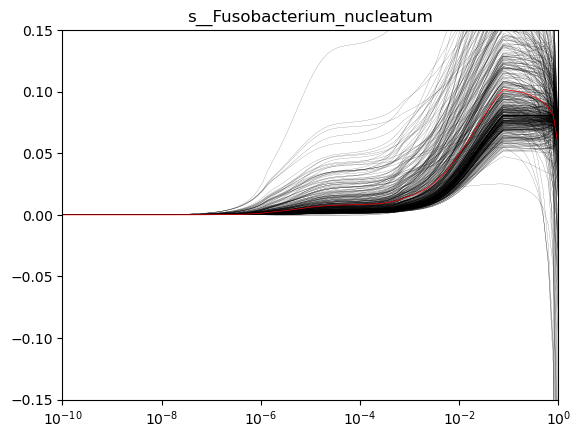

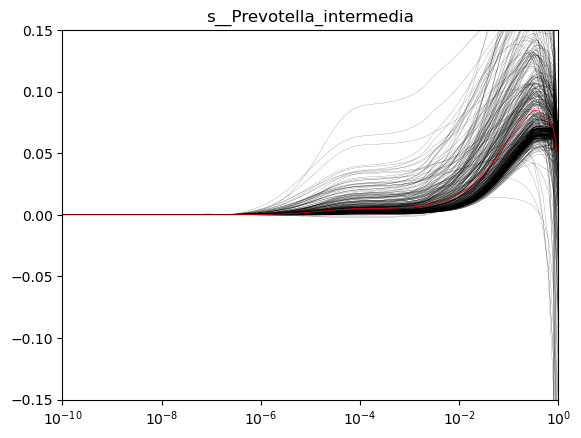

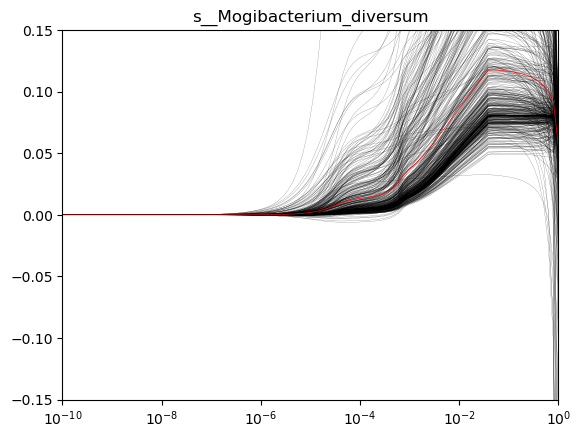

In [27]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
features = [637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/pfnfeature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.15)
    plt.xlim(1e-10,1)
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

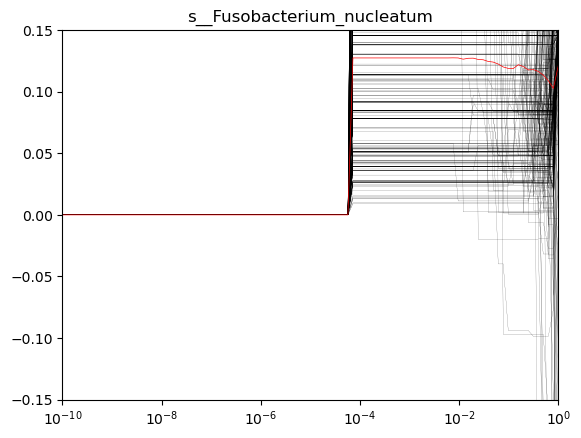

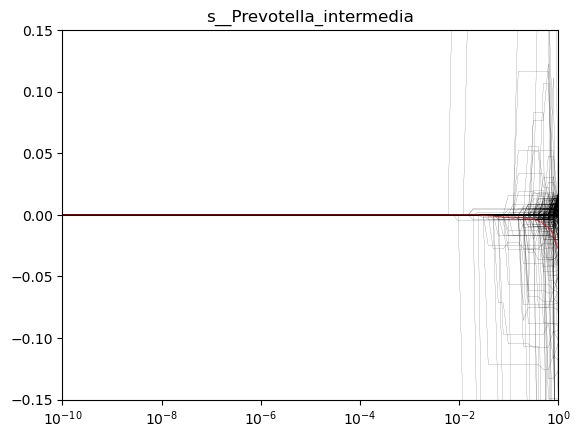

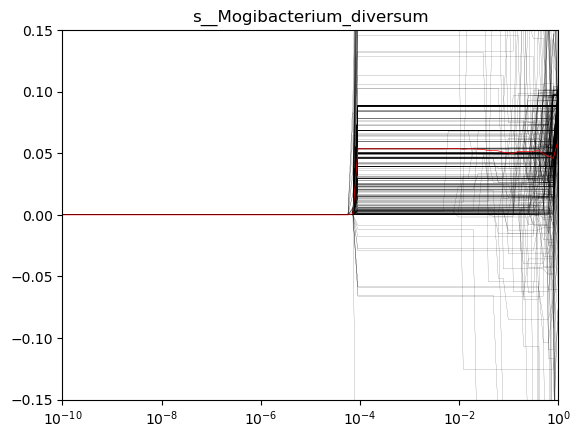

In [32]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
features = [637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/xgbfeature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.15)
    plt.xlim(1e-10,1)
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

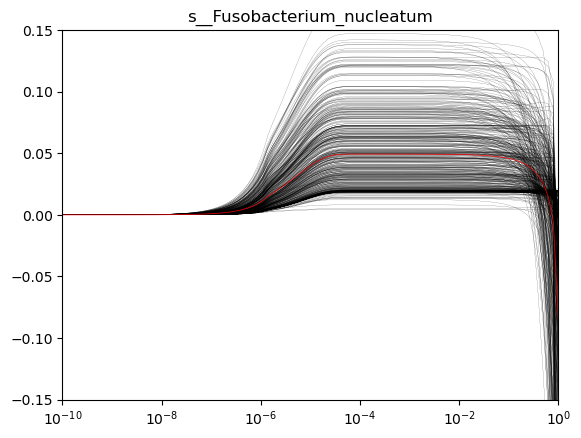

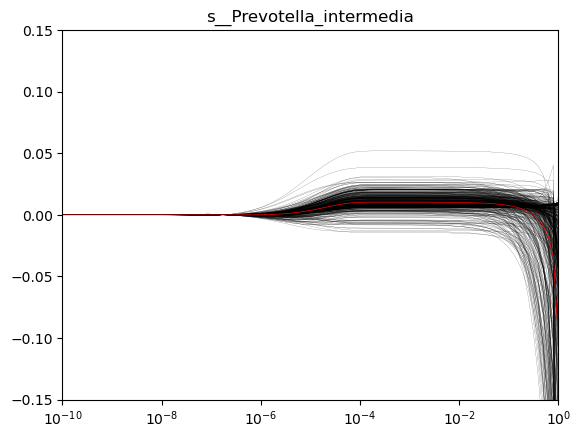

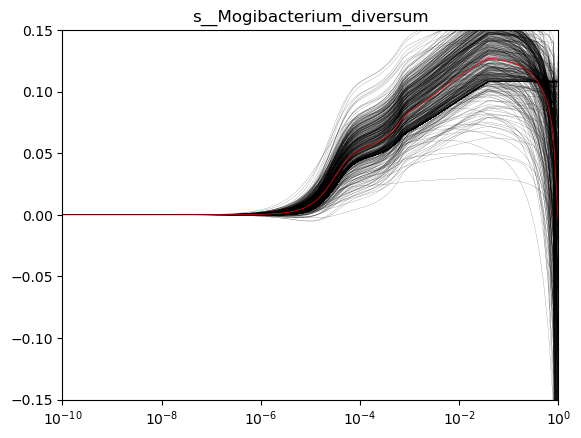

In [30]:

#print(np.where(["Prevotella_inter" in b for b in bacteria_names]))
#print(np.array(bacteria_names)[np.where(["Prevotella_inter" in b for b in bacteria_names])])

num = 100
features = [637, 1063, 921]#+list(best[:50])#[637, 1063]#best[50:100]#[921]
for f in features:
    fvalues = np.geomspace(np.min(all_data[(all_data[:,f]>0),f])+1e-10,np.max(all_data[:,f]),num=num)
    fvalues = np.geomspace(1e-10,1,num=num)
    #print(fvalues)
    #print(ice_curves.shape)
    ice_curves = np.load(f"results/ice/feature{f}.npy")
    for i in range(512):
        plt.plot(fvalues, ice_curves[:,i]-ice_curves[0,i], linewidth=0.1, c="black")
    plt.plot(fvalues, np.mean(ice_curves-ice_curves[0,:], axis=1), linewidth=0.5, c="red")
    plt.ylim(-0.15,0.15)
    plt.xlim(1e-10,1)
    plt.xscale("log")
    plt.title(bacteria_names[f])
    plt.show()

### Data valuation - Leave-one-out (LOO)

In [ ]:
save = True
no_pre_process = False
multi_decoder = "permutation"
N_ens = 3
seed = 42
overwrite = True
metrics = ["roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)

reducer = AnovaSelect()

n_folds = 7
s = all_data.shape[0]
data_c0 = all_data[labels==0]
data_c1 = all_data[labels==1]
c0_frac = data_c0.shape[0]/all_data.shape[0]
c1_frac = 1-c0_frac#data_c1.shape[0]/all_data.shape[0]
X_folds, y_folds = [], []
fs = int(s/n_folds)
for nr in range(n_folds-1):
    fold = np.concatenate((data_c0[int(fs*c0_frac)*nr:int(fs*c0_frac)*(nr+1),:],
                          data_c1[int(fs*c1_frac)*nr:int(fs*c1_frac)*(nr+1),:]),axis=0)
    new_labels = np.concatenate((np.zeros(int(fs*c0_frac)), np.ones(int(fs*c1_frac))))
    X_folds.append(fold)
    y_folds.append(new_labels)
fold = np.concatenate((data_c0[int(fs*c0_frac)*(n_folds-1):],
                      data_c1[int(fs*c1_frac)*(n_folds-1):]),axis=0)
new_labels = np.concatenate((np.zeros(data_c0.shape[0]-int(fs*c0_frac)*(n_folds-1)), np.ones(data_c1.shape[0]-int(fs*c1_frac)*(n_folds-1))))
X_folds.append(fold)
y_folds.append(new_labels)
dvs = []
for run in range(n_folds):
    print(run)
    X_folds = X_folds[run+1:] + X_folds[:run+1]
    y_folds = y_folds[run+1:] + y_folds[:run+1]
    X_test, y_test = np.concatenate(tuple(X_folds[:-1])), np.concatenate(tuple(y_folds[:-1]))
    X_train, y_train = X_folds[-1], y_folds[-1]
    X_train, X_test = remove_same_features_traintest(X_train, X_test)
    X_train, y_train = unison_shuffled_copies(X_train, y_train)
    X_test, y_test = unison_shuffled_copies(X_test, y_test)
    reducer.fit(X_train, y_train)
    X_train = reducer.transform(X_train)
    X_test = reducer.transform(X_test)
    X_test, y_test = X_test[:512], y_test[:512]
    # with datapoint
    model.fit(X_train, y_train, overwrite_warning=True)
    probs = model.predict_proba(X_test)
    #if model_clean.__class__.__name__=="MedPFNClassifier":
    probs = (probs[:,1]-probs[:,0]+1)*0.5
    m = "roc_auc"
    result = sklearn.metrics.get_scorer(m)._score_func(y_test, probs)
    #print(result)
    for x in range(X_train.shape[0]):
        #without datapoint
        X_train_wo = np.delete(X_train, x, axis=0)
        y_train_wo = np.delete(y_train, x, axis=0)
        model.fit(X_train_wo, y_train_wo, overwrite_warning=True)
        probs = model.predict_proba(X_test)
        #if model_clean.__class__.__name__=="MedPFNClassifier":
        probs = (probs[:,1]-probs[:,0]+1)*0.5
        m = "roc_auc"
        result_wo = sklearn.metrics.get_scorer(m)._score_func(y_test, probs)
    dvs.append(result-result_wo)

0
1
2
